# 서울 부동산 시장 분석 및 투자 전략 수립

## 과제 2: 아파트 규모별 가격 트렌드 및 생애주기 투자 전략

전용면적별(소형, 중형, 대형) 아파트의 가격 변동 추이를 분석, 생애주기와 데이터 분석에 따른 최적 투자 전략과 거주 전략을 제시

- 전용면적 기준으로 분류 후 규모별 가격 변동 추이 분석, 시각화
- 생애주기
  - 20~30: 신혼 / 첫 주택 구입 시기 
  - 40~50: 자산 증식 시기
  - 60~  : 다운사이징 / 현금화 단계

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display

warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

df_sales = pd.read_csv('./data/sales_clean.csv')
df_sales['계약일'] = pd.to_datetime(df_sales['계약일'], format='%Y%m%d')

df_sales_copy = df_sales.copy()
df_sales_copy = df_sales_copy[df_sales_copy['공공임대'].isna()]
# display(df_sales_copy.head())

KeyError: '공공임대'

In [ ]:
# 전용면적 기준 분류 및 필요 컬럼 추출
def area(df):
    if df['전용면적'] >= 85:
        return '대형'
    elif df['전용면적'] >= 60:
        return '중형'
    else:
        return '소형'

df_area_analysis = pd.DataFrame({
    '전용면적': df_sales_copy['전용면적'],
    '계약월': pd.to_datetime(df_sales_copy['계약월'], format='%Y-%m-%d'),
    '건축년도': df_sales_copy['건축년도'],
    '거래금액': df_sales_copy['거래금액'],
    '평단가': df_sales_copy['평단가'],
    '면적구분': df_sales_copy.apply(area, axis=1),
    '신축구분': df_sales_copy['건축년도'].apply(lambda x: '신축' if 2025 - x <= 10 else '중고')
})

display(df_area_analysis.head())

,전용면적,계약월,건축년도,거래금액,평단가,면적구분,신축구분
0,84.980,2020-12-01,2013,8.180385e+08,31894205,중형,중고
1,240.305,2020-12-01,2011,7.083016e+09,97675058,대형,중고
2,84.880,2020-12-01,2018,1.795694e+09,70093458,중형,신축
3,104.220,2020-12-01,1978,5.935767e+08,18870917,대형,중고
4,84.920,2020-12-01,2001,1.346771e+09,52549630,중형,중고


In [ ]:
# 월간/연간 통계 분석
from da_utils.calc_monthly_annual import calc_monthly_annual
monthly_stats, annual_stats = calc_monthly_annual(df_area_analysis, '면적구분')
display(monthly_stats, annual_stats)

,면적구분,계약월,월별거래건수,월평균거래금액,월평균평단가,월별수익률,이동평균,이동표준편차
0,대형,2020-01-01,1794,1.051814e+09,2.811883e+07,NaN,NaN,NaN
1,대형,2020-02-01,1176,1.082076e+09,2.921661e+07,0.028365,NaN,NaN
2,대형,2020-03-01,623,1.134991e+09,3.012994e+07,0.047744,NaN,NaN
3,대형,2020-04-01,502,1.314640e+09,3.362868e+07,0.146938,NaN,NaN
4,대형,2020-05-01,1038,1.372923e+09,3.524010e+07,0.043379,NaN,NaN
...,...,...,...,...,...,...,...,...
193,중형,2025-02-01,2662,1.323926e+09,6.154794e+07,0.137240,NaN,NaN
194,중형,2025-03-01,4133,1.253625e+09,5.846085e+07,-0.054563,NaN,NaN
195,중형,2025-04-01,2152,1.003137e+09,4.734206e+07,-0.222907,NaN,NaN
196,중형,2025-05-01,3060,1.123121e+09,5.239205e+07,0.112979,NaN,NaN


,면적구분,연도,연간수익률,변동성
0,대형,2020,0.554504,0.059360
1,대형,2021,0.039284,0.066944
2,대형,2022,-0.260979,0.140610
3,대형,2023,-0.030130,0.071169
4,대형,2024,0.290469,0.049673
5,대형,2025,-0.155503,0.098332
6,소형,2020,0.311191,0.067417
7,소형,2021,0.063644,0.037025
8,소형,2022,-0.279795,0.100813
9,소형,2023,0.386173,0.051250


In [ ]:
# 건축년도 기반 추가분석
## 면적별 전체 분석
year_by_area = df_area_analysis.groupby('면적구분').agg({
    '건축년도': ['mean', 'count'],
    '거래금액': ['mean', 'sum']
    }).reset_index().round(2)
year_by_area.columns = ['면적구분', '평균건축년도', '거래량', '평균거래금액', '총거래금액']

## (면적-신축/중고)에 따른 추가분석
new_old_ratio = df_area_analysis.groupby(['면적구분', '신축구분']).size().reset_index(name='거래량')
new_old_ratio['비율(%)'] = new_old_ratio.groupby('면적구분')['거래량'].apply(lambda x: x * 100 / x.sum()).values.round(2)

# 보기 편하게 정렬
area_order = ['소형', '중형', '대형']
year_by_area['면적구분'] = pd.Categorical(year_by_area['면적구분'], categories=area_order, ordered=True)
year_by_area = year_by_area.sort_values(['면적구분'])

new_old_ratio['면적구분'] = pd.Categorical(new_old_ratio['면적구분'], categories=area_order, ordered=True)
new_old_ratio = new_old_ratio.sort_values(['면적구분'])

display('year_by_area', year_by_area, 'new_old_ratio', new_old_ratio)

'year_by_area'

,면적구분,평균건축년도,거래량,평균거래금액,총거래금액
1,소형,2002.35,112064,7.132385e+08,79928356310000
2,중형,2002.59,108318,1.116395e+09,120925653350000
0,대형,2000.01,42295,1.860383e+09,78684917230000


'new_old_ratio'

,면적구분,신축구분,거래량,비율(%)
2,소형,신축,20524,18.31
3,소형,중고,91540,81.69
4,중형,신축,16780,15.49
5,중형,중고,91538,84.51
0,대형,신축,3180,7.52
1,대형,중고,39115,92.48


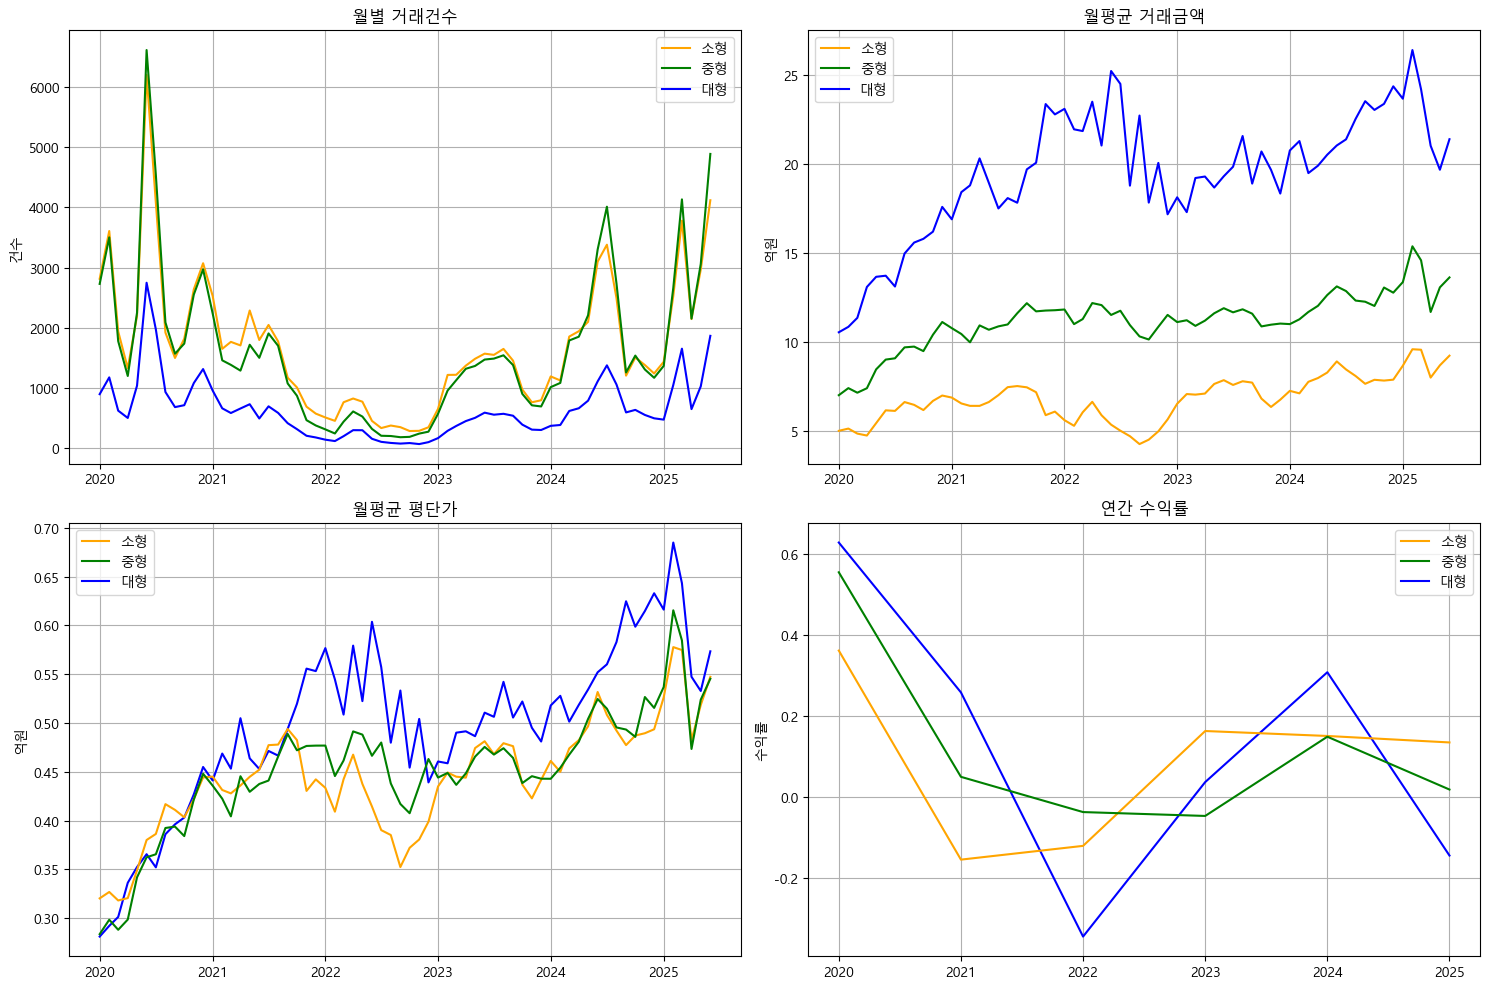

In [ ]:
import matplotlib.pyplot as plt

# 면적구분 목록
area_types = monthly_stats['면적구분'].unique()
colors = ['blue', 'orange', 'green']  # 면적구분별 색상 지정

# Figure와 서브플롯 생성 (2x2)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

# 1. 월별 거래건수
for i, area in enumerate(area_types):
    data = monthly_stats[monthly_stats['면적구분'] == area]
    axes[0].plot(data['계약월'], data['월별거래건수'], label=area, color=colors[i])
axes[0].set_title('월별 거래건수')
axes[0].set_ylabel('건수')
axes[0].legend()
axes[0].grid(True)

# 2. 월평균 거래금액 (억 단위)
for i, area in enumerate(area_types):
    data = monthly_stats[monthly_stats['면적구분'] == area]
    axes[1].plot(data['계약월'], data['월평균거래금액']/1e8, label=area, color=colors[i])
axes[1].set_title('월평균 거래금액')
axes[1].set_ylabel('억원')
axes[1].legend()
axes[1].grid(True)

# 3. 월평균 평단가 (억 단위)
for i, area in enumerate(area_types):
    data = monthly_stats[monthly_stats['면적구분'] == area]
    axes[2].plot(data['계약월'], data['월평균평단가']/1e8, label=area, color=colors[i])
axes[2].set_title('월평균 평단가')
axes[2].set_ylabel('억원')
axes[2].legend()
axes[2].grid(True)

# 4. 월별 수익률
for i, area in enumerate(area_types):
    data = annual_stats[annual_stats['면적구분'] == area]
    axes[3].plot(data['연도'], data['연간수익률'], label=area, color=colors[i])
axes[3].set_title('연간 수익률')
axes[3].set_ylabel('수익률')
axes[3].legend()
axes[3].grid(True)

# 범례 순서 조정
for ax in axes.flat:
    handles, labels = ax.get_legend_handles_labels()
    ordered_handles = [handles[labels.index(o)] for o in area_order if o in labels]
    ordered_labels = [o for o in area_order if o in labels]
    ax.legend(ordered_handles, ordered_labels)


plt.tight_layout()
plt.show()

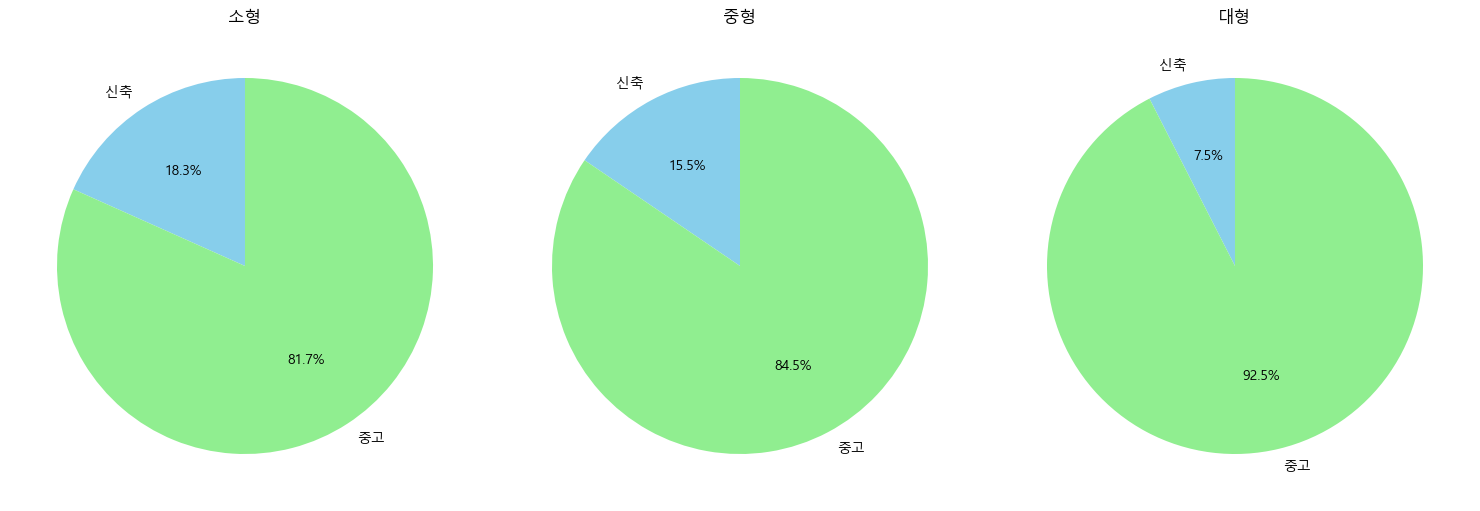

In [ ]:
import matplotlib.pyplot as plt

# 면적별 파이 차트 그리기
area_categories = new_old_ratio['면적구분'].unique()
fig, axes = plt.subplots(1, len(area_categories), figsize=(5 * len(area_categories), 5))

for ax, area in zip(axes, area_categories):
    subset = new_old_ratio[new_old_ratio['면적구분'] == area]
    ax.pie(subset['비율(%)'], labels=subset['신축구분'], autopct='%1.1f%%', startangle=90, colors=['skyblue','lightgreen'])
    ax.set_title(f'{area}')

plt.tight_layout()
plt.show()


## 생애주기 투자 전략 - 가중치 부여 후 점수로 비교할 것

### 선정기준
- 거래량: 진입장벽, 유동성
- 평단가/평균거래금액: 초기 투자금, 자산 규모
- 월/연간 수익률, 변동성: 위험 대비 수익
- 신축구분: 선호도, 신축/중고 별 거래량 차이

### 생애주기
1. 20 ~ 30: 신혼/첫 주택 구입 시기 -> 수입이 적고, 초기 자산 마련 목적
- 거래량: 진입 장벽 낮음, 유동성 조금 낮아도 상관 없음(0)
- 평단가/월평균 거래금액: 초기 투자금 및 자산 규모가 적다.(낮을수록 좋음. -1) 
- 월별/연별 수익률과 변동성: 위험 대비 수익 판단(변동성은 -1, 수익률은 +1)
- 신축/중고: 초기 안정성 및 자산 가치 유지 목적(신축 +1)

1. 40 ~ 60: 자산 증식 시기 -> 자금여력 증가
- 거래량: 거래량이 높을수록 자산 증식 가능성이 높아 선호(+1)
- 평단가/월평균 거래금액: 자산 증식 시기이기 때문에, 투자 여력이 높다(+1)
- 월별/연별 수익률과 변동성: 수익률 극대화 및 리스크 관리(수익률 +1, 변동성 0)
- 신축/중고: 투자 포트폴리오 다양화 및 리스크 분산(0)

1. 60 ~   : 다운사이징, 현금화 시기 -> 노후자금 확보 및 유지비 절감
- 거래량: 안정적 현금화 가능해야 함(+1)
- 평단가/월평균 거래금액: 투자금 회수 용이(0)
- 월별/연별 수익률과 변동성: 가격 변동성 낮은 자산 선호(수익률 0, 변동성 -1)
- 신축/중고: 가격 안정성이 높은 중고 중심(중고 +1)

### 거주 <-> 투자
- 거래량: 거주전략에선 조금 낮아도 상관없음(0) / 투자전략에서는 명확하게 높아야 함(+1)
- 평단가/거래금액: 거주전략에서는 낮을수록 좋음(-1) / 투자전략에서는 수익률이 더 중요함(0)
- 월/연간 수익률, 변동성: 거주전략에서는 낮아도 크게 문제 없음(0) / 투자전략에서는 수익률(+1)이 높고, 변동성이 낮을수록 좋다(-1)
- 신축구분: 거주전략에서는 신축에 선호도가 높음(신축+1) / 투자전략에서는 중고가 거래량이 더 높아 좋다(중고비율에 +1)

In [ ]:
# 1. 가중치 테이블 생성
weights = pd.DataFrame({
    '항목': ['거래량', '평균거래금액', '수익률', '변동성', '신축/중고'],
    '거주전략': [0.2, 0.1, 0.2, 0.2, 0.3],
    '투자전략': [0.3, 0.2, 0.3, 0.1, 0.1]
})

# 2. 데이터프레임에서 필요한 값 계산 및 정규화
# 거래량, 평균거래금액
year_by_area_norm = year_by_area.copy()
year_by_area_norm['거래량_score'] = year_by_area_norm['거래량'] / year_by_area_norm['거래량'].max()
year_by_area_norm['평균거래금액_score'] = year_by_area_norm['평균거래금액'] / year_by_area_norm['평균거래금액'].max()
# display(year_by_area_norm)

# 연간 수익률, 변동성
annual_stats_norm = annual_stats.copy()
annual_stats_norm['연간수익률_score'] = (annual_stats_norm['연간수익률'] - annual_stats_norm['연간수익률'].min()) / (annual_stats_norm['연간수익률'].max() - annual_stats_norm['연간수익률'].min())
annual_stats_norm['변동성_score'] = 1 - (annual_stats_norm['변동성'] - annual_stats_norm['변동성'].min()) / (annual_stats_norm['변동성'].max() - annual_stats_norm['변동성'].min())
# display(annual_stats_norm)

# 신축/중고 비율
new_old_ratio_norm = new_old_ratio.copy()
# 신축=1, 중고=0 기준
new_old_ratio_norm['신축_score'] = new_old_ratio_norm.apply(lambda x: x['비율(%)'] if x['신축구분']=='신축' else 1 - x['비율(%)'], axis=1)

# 면적별로 점수 합산
results = []
for area in year_by_area['면적구분'].unique():
    # 거래량, 평균거래금액
    vol_score = year_by_area_norm.loc[year_by_area_norm['면적구분']==area, '거래량_score'].values[0]
    price_score = year_by_area_norm.loc[year_by_area_norm['면적구분']==area, '평균거래금액_score'].values[0]
    # 연간 수익률, 변동성
    annual_score = annual_stats_norm.loc[annual_stats_norm['면적구분']==area, '연간수익률_score'].mean()
    volat_score = annual_stats_norm.loc[annual_stats_norm['면적구분']==area, '변동성_score'].mean()
    # 신축/중고
    new_score = new_old_ratio_norm.loc[new_old_ratio_norm['면적구분']==area, '신축_score'].mean()
    
    # 거주 전략 점수
    residence_score = (
        vol_score * weights.loc[weights['항목']=='거래량','거주전략'].values[0] +
        price_score * weights.loc[weights['항목']=='평균거래금액','거주전략'].values[0] +
        annual_score * weights.loc[weights['항목']=='수익률','거주전략'].values[0] +
        volat_score * weights.loc[weights['항목']=='변동성','거주전략'].values[0] +
        new_score * weights.loc[weights['항목']=='신축/중고','거주전략'].values[0]
    )
    
    # 투자 전략 점수
    invest_score = (
        vol_score * weights.loc[weights['항목']=='거래량','투자전략'].values[0] +
        price_score * weights.loc[weights['항목']=='평균거래금액','투자전략'].values[0] +
        annual_score * weights.loc[weights['항목']=='수익률','투자전략'].values[0] +
        volat_score * weights.loc[weights['항목']=='변동성','투자전략'].values[0] +
        new_score * weights.loc[weights['항목']=='신축/중고','투자전략'].values[0]
    )
    
    results.append({
        '면적구분': area,
        '거주전략점수': residence_score,
        '투자전략점수': invest_score
    })

strategy_scores = pd.DataFrame(results)
strategy_scores


,면적구분,거주전략점수,투자전략점수
0,소형,-8.907951,-2.547809
1,중형,-9.700990,-2.772254
2,대형,-12.209916,-3.684199


In [ ]:
# 생애주기 정의
lifecycle_groups = ['청년', '중년', '노년']

# 결과 저장용
lifecycle_results = []

for lifecycle in lifecycle_groups:
    for area in year_by_area['면적구분'].unique():
        # 거래량, 평균거래금액
        vol_score = year_by_area_norm.loc[year_by_area_norm['면적구분']==area, '거래량_score'].values[0]
        price_score = year_by_area_norm.loc[year_by_area_norm['면적구분']==area, '평균거래금액_score'].values[0]
        # 연간 수익률, 변동성
        annual_score = annual_stats_norm.loc[annual_stats_norm['면적구분']==area, '연간수익률_score'].mean()
        volat_score = annual_stats_norm.loc[annual_stats_norm['면적구분']==area, '변동성_score'].mean()
        # 신축/중고
        new_score = new_old_ratio_norm.loc[new_old_ratio_norm['면적구분']==area, '신축_score'].mean()
        
        # 거주 전략 점수
        residence_score = (
            vol_score * weights.loc[weights['항목']=='거래량','거주전략'].values[0] +
            price_score * weights.loc[weights['항목']=='평균거래금액','거주전략'].values[0] +
            annual_score * weights.loc[weights['항목']=='수익률','거주전략'].values[0] +
            volat_score * weights.loc[weights['항목']=='변동성','거주전략'].values[0] +
            new_score * weights.loc[weights['항목']=='신축/중고','거주전략'].values[0]
        )
        
        # 투자 전략 점수
        invest_score = (
            vol_score * weights.loc[weights['항목']=='거래량','투자전략'].values[0] +
            price_score * weights.loc[weights['항목']=='평균거래금액','투자전략'].values[0] +
            annual_score * weights.loc[weights['항목']=='수익률','투자전략'].values[0] +
            volat_score * weights.loc[weights['항목']=='변동성','투자전략'].values[0] +
            new_score * weights.loc[weights['항목']=='신축/중고','투자전략'].values[0]
        )
        
        lifecycle_results.append({
            '생애주기': lifecycle,
            '면적구분': area,
            '거주전략점수': residence_score,
            '투자전략점수': invest_score
        })

lifecycle_strategy_scores = pd.DataFrame(lifecycle_results)

# 생애주기별 최적 면적 선택
recommended = []
for lifecycle in lifecycle_groups:
    subset = lifecycle_strategy_scores[lifecycle_strategy_scores['생애주기']==lifecycle]
    residence_choice = subset.loc[subset['거주전략점수'].idxmax(), '면적구분']
    invest_choice = subset.loc[subset['투자전략점수'].idxmax(), '면적구분']
    recommended.append({
        '생애주기': lifecycle,
        '추천거주면적': residence_choice,
        '추천투자면적': invest_choice
    })

recommended_df = pd.DataFrame(recommended)
recommended_df


,생애주기,추천거주면적,추천투자면적
0,청년,소형,소형
1,중년,소형,소형
2,노년,소형,소형


In [ ]:
import pandas as pd
import numpy as np

# 1. 데이터 정규화
def normalize_0_1(series):
    return (series - series.min()) / (series.max() - series.min())

def score_return(series):
    # 수익률과 변동성: 0 기준 -1~1
    return np.clip(series / series.abs().max(), -1, 1)

# 연간 수익률과 변동성 점수화
annual_stats['수익률점수'] = score_return(annual_stats['연간수익률'])
annual_stats['변동성점수'] = -score_return(annual_stats['변동성'])  # 변동성 낮을수록 점수 높게

# 거래량과 평균거래금액 0~1 정규화
year_by_area['거래량점수'] = normalize_0_1(year_by_area['거래량'])
year_by_area['거래금액점수'] = normalize_0_1(year_by_area['평균거래금액'])

# 신축/중고 점수화
new_old_ratio['신축점수'] = np.where(new_old_ratio['신축구분']=='신축', 1, 0)
new_old_ratio['중고점수'] = np.where(new_old_ratio['신축구분']=='중고', 1, 0)

# 2. 전략별 가중치 (평단가 제외)
weights = {
    '거주': {'거래량점수':0.25, '거래금액점수':0.25, '수익률점수':0.25, '변동성점수':0.15, '신축점수':0.10, '중고점수':0},
    '투자': {'거래량점수':0.20, '거래금액점수':0.20, '수익률점수':0.30, '변동성점수':0.15, '신축점수':0, '중고점수':0.15}
}

# 3. 생애주기별 가중치 조정
life_stages = ['청년','중년','노년']
stage_weights = {
    '청년': {'신축점수': 1.2, '중고점수': 0.8},
    '중년': {'신축점수': 1.0, '중고점수': 1.0},
    '노년': {'신축점수': 0.8, '중고점수': 1.2}
}

# 4. 점수 계산 함수
def calc_score(df, strategy):
    df['총점'] = 0
    for col, w in weights[strategy].items():
        df['총점'] += df.get(col,0) * w
    return df

# 5. 생애주기별 점수 계산
results = {}
for stage in life_stages:
    # 거주전략
    df_residence = year_by_area.copy()
    df_residence = calc_score(df_residence, '거주')
    df_residence['총점'] *= stage_weights[stage].get('신축점수',1)
    
    # 투자전략
    df_invest = year_by_area.copy()
    df_invest = calc_score(df_invest, '투자')
    df_invest['총점'] *= stage_weights[stage].get('중고점수',1)
    
    results[stage] = {'거주': df_residence, '투자': df_invest}

# 6. 결과 확인
for stage in life_stages:
    print(f"==== {stage} ====")
    print("거주 전략:")
    print(results[stage]['거주'][['면적구분','총점']].sort_values(by='총점', ascending=False))
    print("투자 전략:")
    print(results[stage]['투자'][['면적구분','총점']].sort_values(by='총점', ascending=False))



==== 청년 ====
거주 전략:
  면적구분        총점
2   중형  0.389326
1   소형  0.300000
0   대형  0.300000
투자 전략:
  면적구분       총점
2   중형  0.20764
1   소형  0.16000
0   대형  0.16000
==== 중년 ====
거주 전략:
  면적구분        총점
2   중형  0.324438
1   소형  0.250000
0   대형  0.250000
투자 전략:
  면적구분       총점
2   중형  0.25955
1   소형  0.20000
0   대형  0.20000
==== 노년 ====
거주 전략:
  면적구분       총점
2   중형  0.25955
1   소형  0.20000
0   대형  0.20000
투자 전략:
  면적구분       총점
2   중형  0.31146
1   소형  0.24000
0   대형  0.24000
